## Second exploration of data

In here we will take a look at processed data and create some plots to explain what we see. We provide answer to the following questions.


    1) How many active taxi there are through time? 
    2) When are the most active hours?
    3) Average moved distance of moving taxis throughout the day.
    4) Average speed of moving taxis throughout the day
    5) Distribution of distances covered by taxis throughout days.
    
    
Note that all this analysis is on all the data within the 5th ring of Beijing. The results may vary a lot depending on a sector, which this notebook does not cover.

In [33]:
import sys
sys.path.append("../") # Add parent dir to source
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium import plugins
from folium.plugins import HeatMap
import datetime

import matplotlib.ticker as ticker
import matplotlib.dates as mdates


In [2]:
df = pd.read_pickle("../processed_data/fully_processed.pkl")

## Activity through time


    1) How many taxi's have logged GPS past 30 minutes.
    2) How many taxi's have moved more than 1000 meters (Haversine) past 30 minutes.

In [3]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Source: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

### Count of taxies logging

In [23]:
taxi_activity = df.set_index("time").groupby(
    ["taxi_id", pd.Grouper(freq="30min")]
).first().reset_index().set_index("time").groupby(pd.Grouper(freq="30min")).count()

taxi_activity = taxi_activity.reset_index()[["time", "taxi_id"]].rename(columns={"taxi_id": "count"})

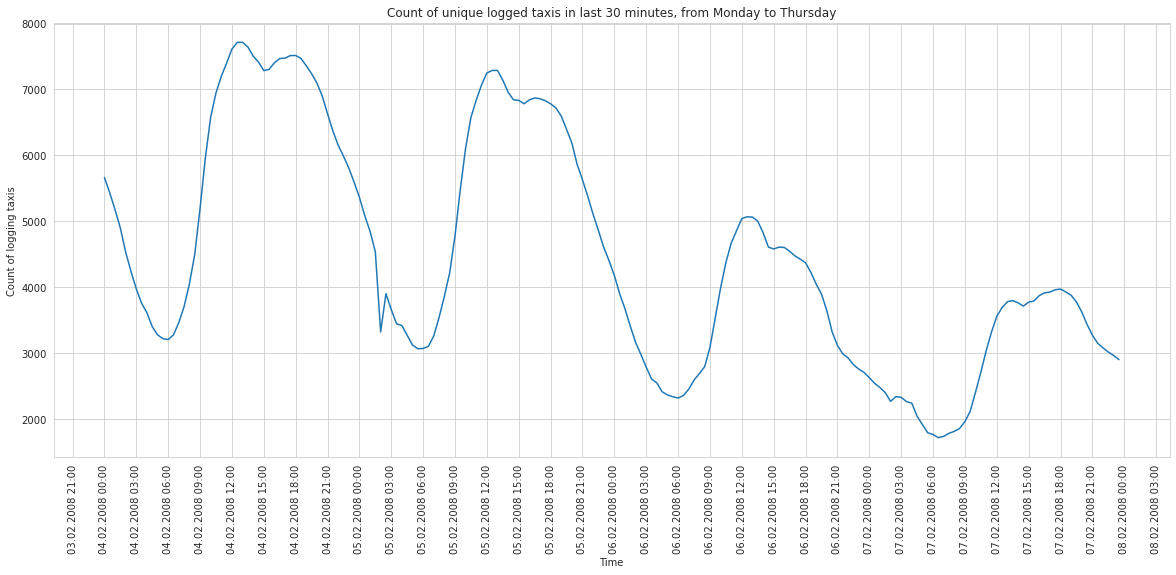

In [68]:
plt.rcParams["figure.figsize"] = (20,8)

sns.set_style("whitegrid")
loc = plticker.MultipleLocator(base=0.125)
axes =  sns.lineplot(data=taxi_activity, x="time", y="count")
axes.xaxis.set_major_locator(loc)
axes.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y %H:%M'))

for label in axes.get_xticklabels():
    label.set_rotation(90)

plt.title("Count of unique logged taxis in last 30 minutes, from Monday to Thursday")
plt.ylabel("Count of logging taxis")
plt.xlabel("Time")
plt.show()



plt.show()


From the plot above we can see that the most number of taxies logged past 30 minutes reach peak around midday and start dropping after 18:00.

Taxis become least active at 6 in the morning.

We also see a noticeable decrease in number of GPS-logging taxis as week moves forward. Monday and Tuesday have many more actively logging taxies compared to Wednesday and Thursday.

The general trend seems to be the same with some day number having some multiplicative. However, we can't say it too confidently having only a week's data. 

## Count of taxies moving

Although taxies may be logging, lets see similar graph, but only include taxies that have moved at least 1000 meters (might play around with this). Some taxis may just be having a pause in one location or not having a client.

To do this we group taxis by id and time and see if total distance moved past 30 minutes is more than 1000 meters.

In [69]:
df[["long_prev", "lat_prev", "time_prev"]] = df.groupby('taxi_id')[['long', 'lat', "time"]].shift()
df["distance_from_prev"] = haversine_np(df["long"], df["lat"], df["long_prev"], df["lat_prev"])



In [83]:
taxi_moving_activity = df.set_index("time").groupby(
    ["taxi_id", pd.Grouper(freq="30min")]
).sum()
# Keep these intervals with Haversine distance sum more than 1 km
taxi_moving_activity = taxi_moving_activity[taxi_moving_activity["distance_from_prev"] > 1]

taxi_moving_activity = taxi_moving_activity.reset_index().set_index("time").groupby(
    pd.Grouper(freq="30min")).count()

taxi_moving_activity = taxi_moving_activity.reset_index()[["time", "taxi_id"]].rename(columns={"taxi_id": "count"})
 

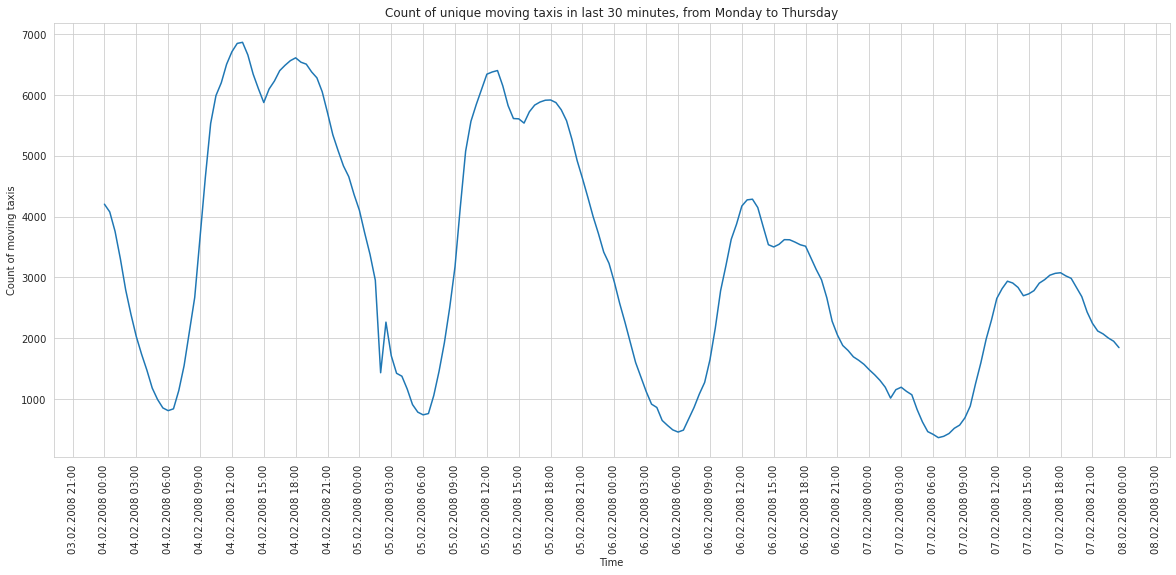

In [84]:
plt.rcParams["figure.figsize"] = (20,8)

sns.set_style("whitegrid")
loc = plticker.MultipleLocator(base=0.125)
axes =  sns.lineplot(data=taxi_moving_activity, x="time", y="count")

axes.xaxis.set_major_locator(loc)
axes.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y %H:%M'))

for label in axes.get_xticklabels():
    label.set_rotation(90)

plt.title("Count of unique moving taxis in last 30 minutes, from Monday to Thursday")
plt.ylabel("Count of moving taxis")
plt.xlabel("Time")
plt.show()

In [85]:
# Merge datasets
taxi_activity["class"] = "logging"
taxi_moving_activity["class"] = "moving"

merged_taxi_activity = pd.concat([taxi_activity, taxi_moving_activity])

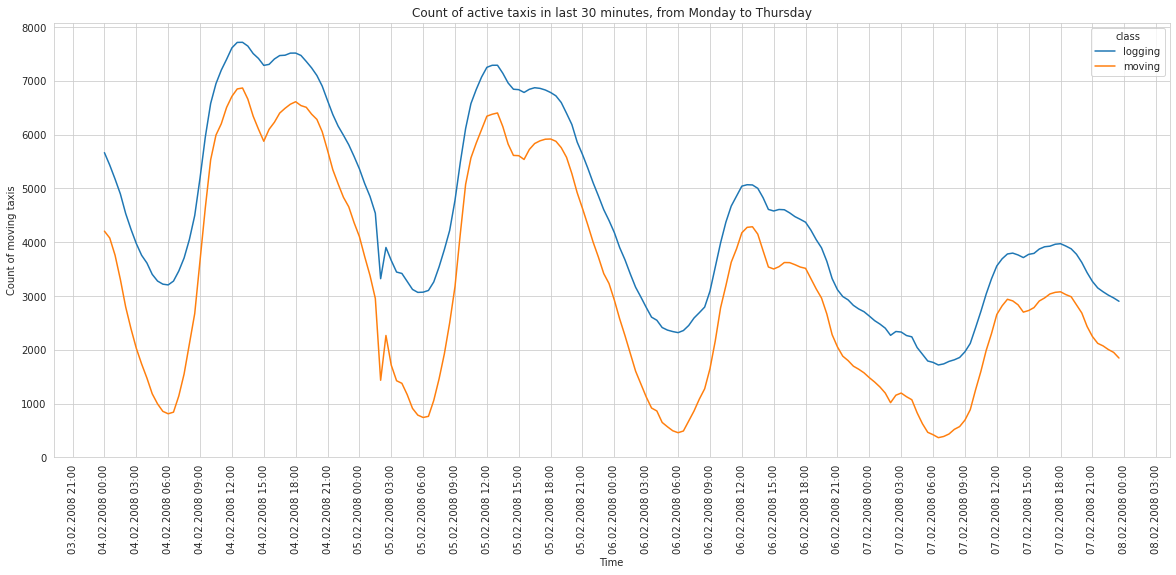

In [87]:
plt.rcParams["figure.figsize"] = (20,8)

sns.set_style("whitegrid")
loc = plticker.MultipleLocator(base=0.125)
axes =  sns.lineplot(data=merged_taxi_activity, x="time", y="count", hue="class")

axes.xaxis.set_major_locator(loc)
axes.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y %H:%M'))

for label in axes.get_xticklabels():
    label.set_rotation(90)

plt.title("Count of active taxis in last 30 minutes, from Monday to Thursday")
plt.ylabel("Count of moving taxis")
plt.xlabel("Time")
plt.show()

From the above plot we can see, that not all taxis that are logging GPS data are not necessarily moving. They may be waiting for a client (or just have forgotten the logger on). Also some difference could be due to a traffic congestion if the taxi has moved less than 1 km in last 30 min.

What we can see is that during nighttimes and especially early in the morning, there are many more logging taxis than moving. There are many more inactive taxis during the nighttime. During daytime most of the logging taxis are also moving, hence they are active.


#### Hardest and easiest time to find an empty taxi

According to the graph above, I could, with some hesitation, say that it is easiest to find taxi during nighttime. Especially early in the morning (3-6 am) as during that times there are many more logging taxis than moving.

It seems to be the hardest to find an empty taxi at the start and the end of the workday. This is when the gap between the lines is the smallest. 



Note that this is just heuristic-based :) Also, results may vary depending on the heuristic of classifying a taxi as "moving"

#### Difference between logging and moving

Lets also plot the difference between logging and moving counts.

In [90]:
merged_act = taxi_activity.merge(taxi_moving_activity, on="time")
merged_act["diff"] =  merged_act["count_x"] - merged_act["count_y"]


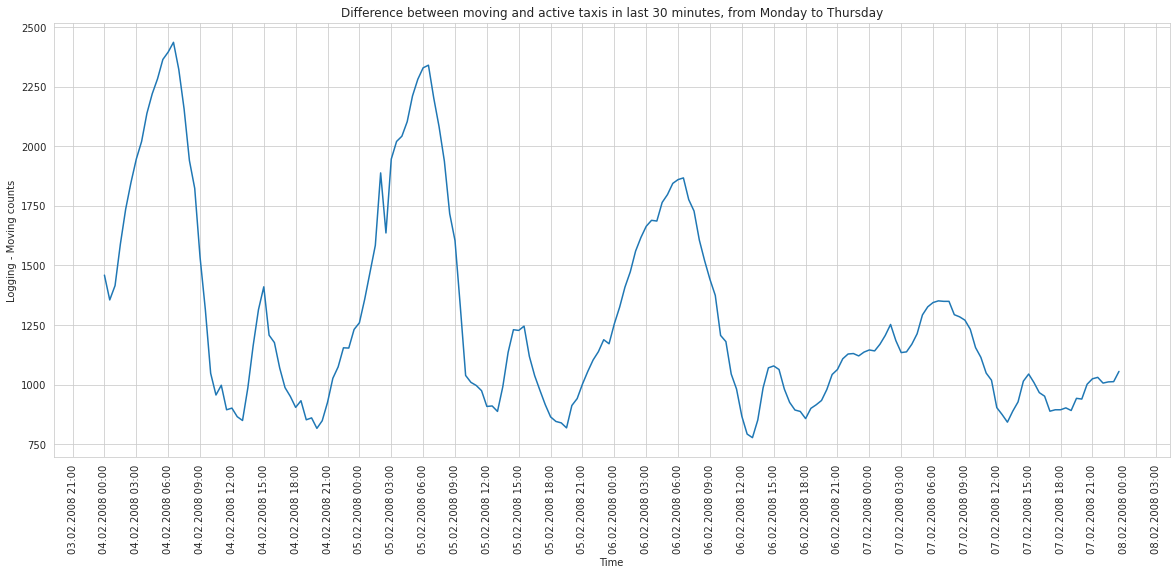

In [91]:
plt.rcParams["figure.figsize"] = (20,8)

sns.set_style("whitegrid")
loc = plticker.MultipleLocator(base=0.125)
axes =  sns.lineplot(data=merged_act, x="time", y="diff")

axes.xaxis.set_major_locator(loc)
axes.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y %H:%M'))

for label in axes.get_xticklabels():
    label.set_rotation(90)

plt.title("Difference between moving and active taxis in last 30 minutes, from Monday to Thursday")
plt.ylabel("Logging - Moving counts")
plt.xlabel("Time")
plt.show()

The plot above shows the difference between counts of logging and moving taxis. If we count taxi as moving, we could say that it is taken / moving a passenger. Therefore the above plot is some estimation to the number of "free" taxies.

From the plot above, we can see that it is easiest to find an empty taxi 6 am in the morning and more difficult at the start of the workday to midday (9-12). Also during the evening (17-21).

However, we can't really say that it is more difficult to find taxi during Wednesday or Thursday. Just having less moving taxis might mean that there is also less demand! Having less demand could mean that it is actually easier to find taxi during Thursday, even though the difference is smaller. 

Therefore it only makes sense to look differences during the same day of the week.


### Moved distance and speed

Lets see how the distance and average speed of active taxies vary throughout days. I'm hoping to see that speeds are slower during the day and faster during the nighttime. This variation would be due to the traffic factor. 

To do this we will look at much higher granularity of time sampling. 15 minute granularity might be bad as the car might just be waiting for some of that period.. Therefore the found means for average speeds are underestimations of actual speeds, as they might not factor for some periods of non-moving. 

In addition, since Haversine distance is the length of shortest line on globe, then this is also an underestimation as it does not account for road structure.


However, the differences throughout the day could show some times where taxis move slower, indicating at traffic congestions etc.



To do this we need to perform 2 tasks here:

    1) Find whether a taxi is moving.
        It doesn't make sense to count taxis which are waiting for clients!
    2) Calculate average speed during the moving period
    
#### Find whether a taxi is moving

Heuristic to check if taxi is moving:
    
    Check if taxi has moved more than 500 meters past 15 minutes. This would count as moving.
    
#### Calculate average speed
    
If taxi has moved more than 500 meters past 15 minutes, then calculate average speed during that period.



In [123]:
taxi_moving_speed = df.set_index("time").groupby(
    ["taxi_id", pd.Grouper(freq="15min")]
).sum()

# Keep these intervals with Haversine distance sum more than 0.5 km
taxi_moving_speed = taxi_moving_speed[taxi_moving_speed["distance_from_prev"] > 0.5]

# We can just multiply by 4 to get km/h, as we had 15 min sampling
taxi_moving_speed["kmh"] = taxi_moving_speed["distance_from_prev"] * 4


In [124]:
# Mean speed
taxi_moving_speed["kmh"].mean()

19.624986593494377

In [125]:
# Group by time of the day. Aggregate mean kmh over all active taxis for that time slot.

moving_speeds = taxi_moving_speed.reset_index().set_index("time").groupby(pd.Grouper(freq="15min")).mean()
moving_speeds = moving_speeds.reset_index()

In [127]:
moving_speeds

,time,taxi_id,long,lat,long_prev,lat_prev,distance_from_prev,kmh
0,2008-02-04 00:00:00,5159.041548,470.429894,161.353709,354.040123,121.432178,3.734666,14.938665
1,2008-02-04 00:15:00,5142.848600,440.949756,151.242498,436.808595,149.821651,5.375750,21.503000
2,2008-02-04 00:30:00,5176.286986,438.229215,150.310044,436.307525,149.651691,5.422345,21.689378
3,2008-02-04 00:45:00,5151.026135,423.268692,145.179257,421.825358,144.686386,5.478167,21.912670
4,2008-02-04 01:00:00,5147.624535,426.967580,146.441733,425.600648,145.974920,5.603008,22.412032
...,...,...,...,...,...,...,...,...
379,2008-02-07 22:45:00,5268.969432,443.916368,152.241855,443.916305,152.242965,5.688035,22.752141
380,2008-02-07 23:00:00,5270.012864,450.870288,154.624740,450.868664,154.624695,5.659069,22.636276
381,2008-02-07 23:15:00,5239.824971,444.547244,152.455191,444.546230,152.456334,5.770822,23.083287
382,2008-02-07 23:30:00,5272.839484,450.581409,154.524363,450.580580,154.524730,5.776141,23.104564


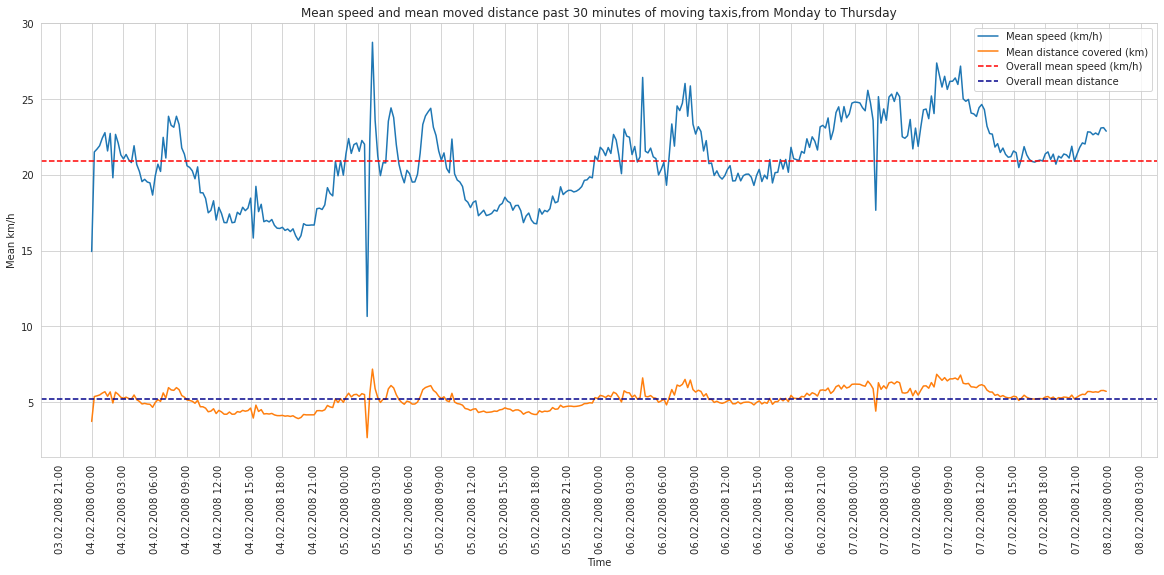

In [138]:
plt.rcParams["figure.figsize"] = (20,8)

sns.set_style("whitegrid")
loc = plticker.MultipleLocator(base=0.125)
axes =  sns.lineplot(data=moving_speeds, x="time", y="kmh", label="Mean speed (km/h)")
axes =  sns.lineplot(data=moving_speeds, x="time", y="distance_from_prev", label="Mean distance covered (km)")

axes.xaxis.set_major_locator(loc)
axes.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y %H:%M'))

axes.axhline(moving_speeds["kmh"].mean(), ls='--', label="Overall mean speed (km/h)", color="red")
axes.axhline(moving_speeds["distance_from_prev"].mean(), ls='--', label="Overall mean distance", color="darkblue")
plt.legend()


for label in axes.get_xticklabels():
    label.set_rotation(90)

plt.title("Mean speed and mean moved distance past 30 minutes of moving taxis,from Monday to Thursday")
plt.ylabel("Mean km/h")
plt.xlabel("Time")
plt.show()

### Results

Indeed, during the usually busiest times of the day (morning to evening), the mean speeds are smaller. And during nighttimes the mean speed is greater (most likely due to no traffic).

We can also see that for Wednesday and Thursday the speeds during daytime are greater compared to Monday and Tuesday.

There is an artefact during the nighttime of 5th February - large drop and then back up to compensate. This might be due to how the data was resampled.


Note: To make the plot correct, a second axis name for distance covered should be added. But I guess it is understandable as it is.

## Distance covered per day

Lets also see how much distance do taxis cover per day.

In [144]:
distance_covered = df.set_index("time").groupby(["taxi_id", pd.Grouper(freq="1D")]).sum().reset_index()
distance_covered = distance_covered.rename(columns={"distance_from_prev": "distance"})

In [145]:
distance_covered.head()

,taxi_id,time,long,lat,long_prev,lat_prev,distance
0,1,2008-02-04,699.05924,239.46929,582.54252,199.56042,9.879497
1,1,2008-02-05,3959.96661,1357.69620,3959.97996,1357.69814,85.562503
2,1,2008-02-06,1980.05686,678.45491,1980.05641,678.45492,55.359055
3,1,2008-02-07,699.02513,239.53264,699.01164,239.52822,21.046064
4,2,2008-02-04,31313.60215,10731.71166,31197.14343,10691.83090,211.010348


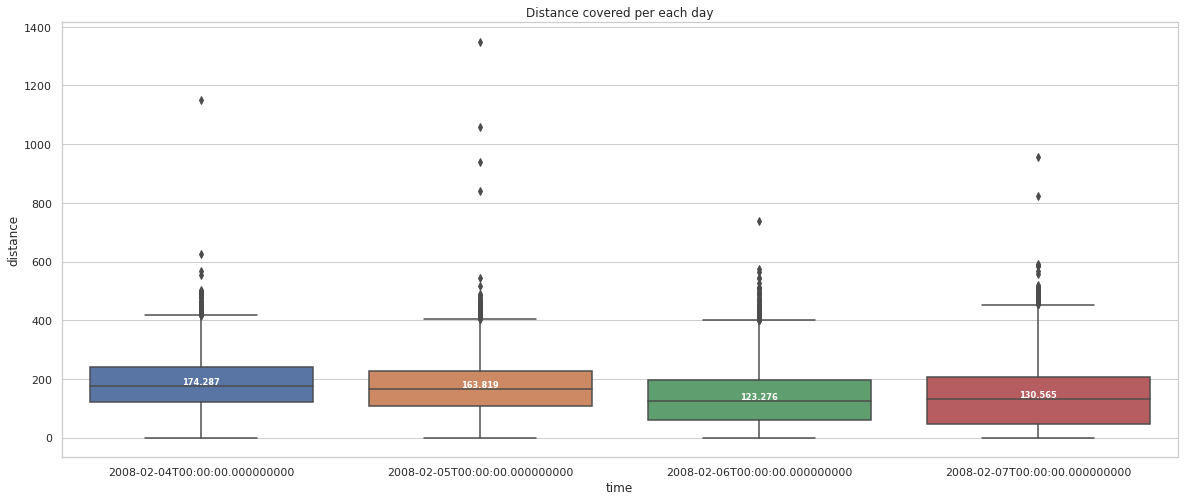

In [159]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="time", y="distance", data=distance_covered)
plt.title("Distance covered per each day")

medians = distance_covered.groupby("time")['distance'].median()
vertical_offset = distance_covered['distance'].median() * 0.05 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, np.round(medians[xtick], 3), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')


plt.show()

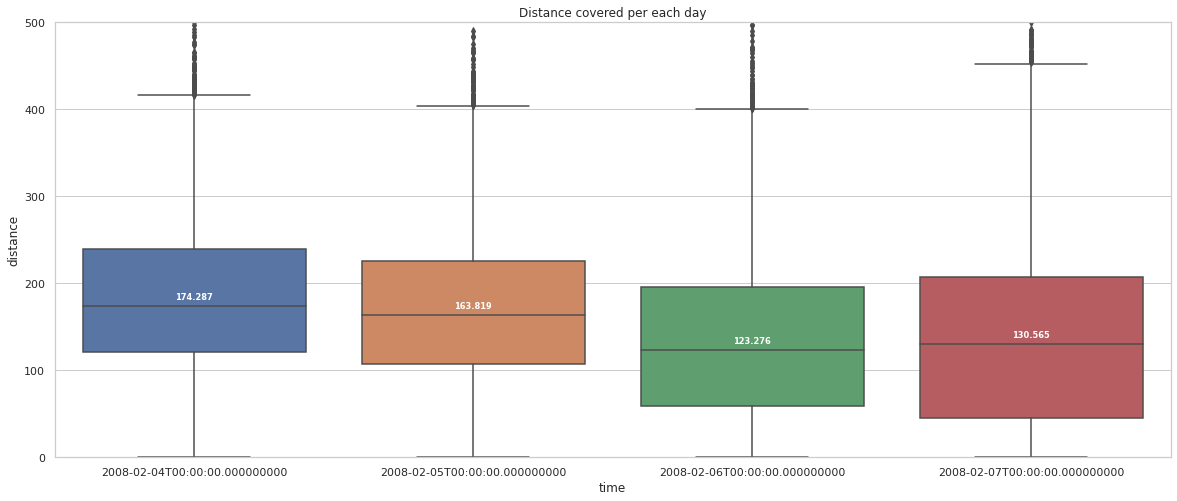

In [158]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="time", y="distance", data=distance_covered)
plt.title("Distance covered per each day")

medians = distance_covered.groupby("time")['distance'].median()
vertical_offset = distance_covered['distance'].median() * 0.05 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, np.round(medians[xtick], 3), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')


plt.ylim(0, 500)

plt.show()

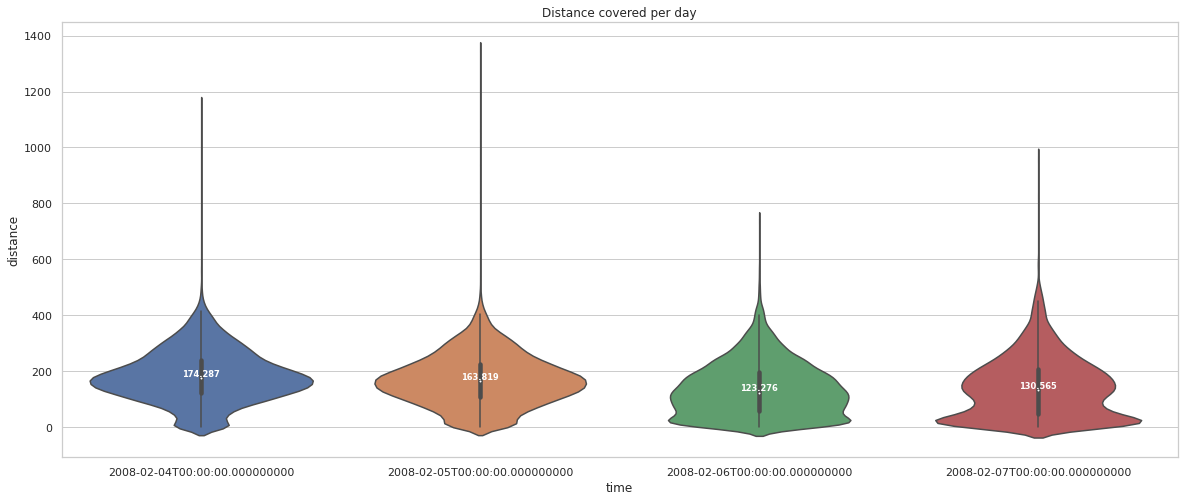

In [160]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x="time", y="distance", data=distance_covered)
plt.title("Distance covered per day")

medians = distance_covered.groupby("time")['distance'].median()
vertical_offset = distance_covered['distance'].median() * 0.05 # offset from median for display

for xtick in ax.get_xticks():
    ax.text(xtick, medians[xtick] + vertical_offset, np.round(medians[xtick], 3), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')


plt.show()

### Results

We can see that taxis actually drive quite a bit per day! On Monday, the median Haversine distance covered is 174 km! With close to same on Tuesday. On Wednesday and Thursday there is less distance covered.


From violin plots we can kind of spot a normal distribution for Monday and Tuesday.. But with a long tail for some really long trips. Wednesday and Thursday are not really normal. Could make some QQ-plots here to show that, but I guess that doesn't add much for now.

From the violin plot we also note that on Wednesday and Thursday there are quite a bit more taxis, which drive through only a short distance. The most dense part of the distribution for Thursday is pretty close to 0! I'd say around ~15 km by eye. 

There are also some taxis that drive more than 1000 km a day! Which is actually something that should be looked at if it is not actually some error..